So far I have been checking [eli5][1] and [treeinterpreter][2] (both have been mentioned before) and I think eli5 will be the most helpfull, because I think have more options and is more generic and updated.



Nevertheless after some time I apply eli5 for a particular case and I could not obtained negative contributions for [ExtraTreesClassifier][3] researching a little bit more I realised I was obtaining the importance or weight as seen [here][4]. Because I was more interested in something like contribution, as mentioned of the title of this questions, I understand some feature could have a negative effect but when measuring the importance the sign is not important, so feature with positive effects and negatives are put together.

Because I was very interested in the sign I did as follows:
1) obtain the contributions for all cases
2) agreage all the results to be able to distinguish the same.
No very elegant solution, probably there is something better out there, I post it here in case it helps.

I reproduce the same that [previous post][5].

  [1]: http://eli5.readthedocs.io/en/latest/overview.html
  [2]: https://github.com/andosa/treeinterpreter
  [3]: http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.ExtraTreesClassifier.html
  [4]: http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html
  [5]: https://stackoverflow.com/a/35255612/7127519

In [96]:
from sklearn import datasets
from sklearn.cross_validation import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import  (ExtraTreesClassifier, RandomForestClassifier, 
                              AdaBoostClassifier, GradientBoostingClassifier)
import eli5
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


iris = datasets.load_iris()  #sample data
X, y = iris.data, iris.target
#split into training and test 
X_train, X_test, y_train, y_test = train_test_split( 
    X, y, test_size=0.33, random_state=0)

# fit the model on the training set
#model = DecisionTreeClassifier(random_state=0)
model = ExtraTreesClassifier(n_estimators= 100)

model.fit(X_train,y_train)

ExtraTreesClassifier(bootstrap=False, class_weight=None, criterion='gini',
           max_depth=None, max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [2]:
y_train

array([1, 2, 1, 1, 2, 2, 2, 2, 1, 2, 1, 0, 2, 1, 1, 1, 1, 2, 0, 0, 2, 1, 0,
       0, 1, 0, 2, 1, 0, 1, 2, 1, 0, 2, 2, 2, 2, 0, 0, 2, 2, 0, 2, 0, 2, 2,
       0, 0, 2, 0, 0, 0, 1, 2, 2, 0, 0, 0, 1, 1, 0, 0, 1, 0, 2, 1, 2, 1, 0,
       2, 0, 2, 0, 0, 2, 0, 2, 1, 1, 1, 2, 2, 1, 1, 0, 1, 2, 2, 0, 1, 1, 1,
       1, 0, 0, 0, 2, 1, 2, 0])

In [3]:
type(X_train)

numpy.ndarray

In [90]:
# Let's check the weight. As you can see they are positive. So they looks like they only can be positive.
eli5.show_weights(model, top=10)

Weight,Feature
0.4479 ± 0.4980,x3
0.3920 ± 0.4878,x2
0.0968 ± 0.2311,x0
0.0633 ± 0.1422,x1


Feature ranking:
1. feature 3 (0.474509)
2. feature 2 (0.373542)
3. feature 0 (0.098248)
4. feature 1 (0.053701)


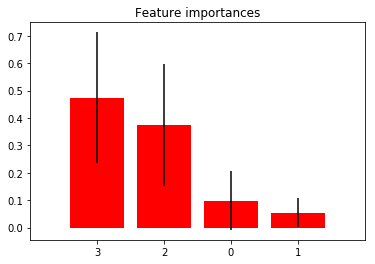

In [97]:
# So I investigate I little bit more and check how those weight are effective calculated :
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_forest_importances.html 

forest = model 
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest
plt.figure()
plt.title("Feature importances")
plt.bar(range(X.shape[1]), importances[indices],
       color="r", yerr=std[indices], align="center")
plt.xticks(range(X.shape[1]), indices)
plt.xlim([-1, X.shape[1]])
plt.show()

Previous results only can be positive. But I want the effect / contribution of each variable an it can be negative.
Searching a little bit in eli5 I see there is the possibility to find those result for particular cases.

In [66]:


aux1 = eli5.sklearn.explain_prediction.explain_prediction_tree_classifier(model,X[0], top=X.shape[0])
aux1 = eli5.format_as_dataframe(aux1)
# aux1.index = aux1['feature']
# del aux1['target']
aux1

,target,feature,weight,value
0,0,<BIAS>,0.340000,1.0
1,0,x3,0.285764,0.2
2,0,x2,0.267080,1.4
3,0,x1,0.058208,3.5
4,0,x0,0.048949,5.1
5,1,<BIAS>,0.310000,1.0
6,1,x0,-0.004606,5.1
7,1,x1,-0.048211,3.5
8,1,x2,-0.111974,1.4
9,1,x3,-0.145209,0.2


I want that but in my whole population. That will help me to understand the average effect or contribution of 
each variable / feature alone.

So I create a function to combine previous kind of tables:

In [87]:
def concat_average_dfs(aux2,aux3):
    # Putting the same index together
#     I use the try because I want to use this function recursive and 
#     I could potentially introduce dataframe with those indexes. This
#     is not the best way.
    try:
        aux2.set_index(['feature', 'target'],inplace = True)
    except:
        pass
    try:
        aux3.set_index(['feature', 'target'],inplace = True)
    except:
        pass
    # Concatenating and creating the meand
    aux = pd.DataFrame(pd.concat([aux2['weight'],aux3['weight']]).groupby(level = [0,1]).mean())
    # Return in order
    #return aux.sort_values(['weight'],ascending = [False],inplace = True)
    return aux
aux2 = aux1.copy(deep=True)
aux3 = aux1.copy(deep=True)

concat_average_dfs(aux3,aux2)

weight
feature target          
<BIAS>  0       0.340000
        1       0.310000
        2       0.350000
x0      0      -0.016759
        1       0.016727
        2       0.000031
x1      0      -0.006055
        1      -0.038560
        2       0.044615
x2      0      -0.165008
        1      -0.176310
        2       0.341318
x3      0      -0.152178
        1      -0.111858
        2       0.264036

In [88]:
range(X.shape[0])

range(0, 150)

So now I only have to use previous function with all the examples I wish. I will take the whole population not only the training set. Check the average effect in all real cases:

In [89]:
# Check the average effect in all real cases
for i in range(X.shape[0]):

    
    aux1 = eli5.sklearn.explain_prediction.explain_prediction_tree_classifier(model,X[i], top=X.shape[0])
    aux1 = eli5.format_as_dataframe(aux1)
    
    if 'aux_total'  in locals() and 'aux_total' in  globals():
        aux_total = concat_average_dfs(aux1,aux_total)
    else:
        aux_total = aux1
aux_total

weight
feature target          
<BIAS>  0       0.340000
        1       0.310000
        2       0.350000
x0      0      -0.027712
        1       0.010482
        2       0.017230
x1      0      -0.001759
        1      -0.023142
        2       0.024901
x2      0      -0.156598
        1      -0.129817
        2       0.286415
x3      0      -0.153931
        1      -0.167408
        2       0.321339

  Las table show the average effects of each feature for all my real population.
